# **Adversarial Training on CIFAR-10**


## **Overview**
This notebook demonstrates how adversarial training improves model robustness on the CIFAR-10 dataset. By using algorithms such as **Fast Gradient Sign Method (FGSM)** , **PGD** (Projected Gradient Descent) for generating adversarial examples, we analyze the model's behavior under attack and enhance its defenses with **Adversarial Training**.

---

## **Table of Contents**

1. [Natural Setting](#Natural-Setting)  
   - [Model Architecture](#Model-Architecture)  
    - [Clean Results](#Clean-Results)  

2. [Fast Gradient Sign Method (FGSM) Attacks on CIFAR-10](#Fast-Gradient-Sign-Method-FGSM-Attacks-on-CIFAR-10)  
    - [What is FGSM?](#What-is-FGSM)  
    - [Goals of This Section](#Goals-of-This-Section)  
    - [FGSM Attack Implementation](#FGSM-Attack-Implementation)  
    - [Impact of $\epsilon$ (FGSM Evaluation)](#Impact-of-epsilon-FGSM-Evaluation)  
    - [Visualize Attack Impact on Classification](#Visualize-Attack-Impact-on-Classification)  
    - [Evaluate Accuracy Under FGSM Attacks](#Evaluate-Accuracy-Under-FGSM-Attacks)  

3. [Projected Gradient Descent (PGD)](#Projected-Gradient-Descent-PGD)  
    - [What is PGD?](#What-is-PGD)  
    - [Implementation of PGD](#Implementation-of-PGD)  
        - [PGD Function](#PGD-Function)  
        - [Testing with PGD](#Testing-with-PGD)  
        - [Running PGD and Observing Results](#Running-PGD-and-Observing-Results)  
        - [Plot Accuracy Under PGD Attack](#Plot-Accuracy-Under-PGD-Attack)

4. [Adversarial Training](#Adversarial-Training)  
    - [What is Adversarial Training?](#What-is-Adversarial-Training)  
    - [Implementation of Adversarial Training](#Implementation-of-Adversarial-Training)  
        - [Define Adversarial Training Function](#Define-Adversarial-Training-Function)  
        - [Training the Model with Adversarial Examples](#Training-the-Model-with-Adversarial-Examples)  
        - [Testing the Adversarially Trained Model](#Testing-the-Adversarially-Trained-Model)  
        - [Comparing Results](#Comparing-Results)  
        - [Visualizing Results](#Visualizing-Results)






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If you are using Google Colab, put the name of your directory here.

In [ ]:
%cd /content/drive/MyDrive/EE526_S25

[Errno 2] No such file or directory: '/content/drive/MyDrive/EE526_S25'
/content


## Import Packages

In [ ]:
# Cell: Install and Import Libraries
import os
import sys
import argparse
import importlib.util
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt

# Check device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Basic Model

## Define the Architecture of the Model

This is a small CNN model that will be used throughout this notebook. It is small for fast training. If you like, then you may add in extra layers and functions or use your pretrained model from the first part of the assignment.

In [ ]:
# Cell: Define the Neural Network Model
class Net(nn.Module):
    model_file = "default_model.pth"  # Default model file

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def save(self, model_file):
        torch.save(self.state_dict(), model_file)

    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, weights_only=True, map_location=device))

## Load & Prepare CIFAR10 dataset

In [ ]:
# Cell: Prepare Data
def get_train_loader(dataset, valid_size=1024, batch_size=32):
    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
    return train_loader

def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    valid_loader = torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)
    return valid_loader

In [ ]:
# Cell 3: Prepare CIFAR-10 Dataset
def get_train_loader(dataset, valid_size=1024, batch_size=32):
    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    return torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    return torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)

# Define data transformations
# transform = transforms.Compose([transforms.ToTensor()])

# Define data transformations
train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

# Create loaders
train_loader = get_train_loader(train_dataset, batch_size=32)
test_loader = get_validation_loader(test_dataset, batch_size=32)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


## Build Train & Test Functions

In [ ]:
# Cell 4: Training Function
def train_model(net, train_loader, model_file, num_epochs=20):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    print("Starting training...")
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    net.save(model_file)
    print(f"Model saved to {model_file}")

# Cell 5: Testing Function
def test_natural(net, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

## Training Loop

In [ ]:
# Cell 6: Train and Evaluate the Model
net = Net().to(device)
model_file = "cifar10_model.pth"

# Train the model
train_model(net, train_loader, model_file, num_epochs=15)

# Evaluate the model
net.load(model_file)
accuracy = test_natural(net, test_loader)
print(f"Natural Test Accuracy: {accuracy:.2f}%")

Starting training...
Epoch 1, Loss: 1.7373
Epoch 2, Loss: 1.4470
Epoch 3, Loss: 1.3431
Epoch 4, Loss: 1.2741
Epoch 5, Loss: 1.2170
Epoch 6, Loss: 1.1765
Epoch 7, Loss: 1.1323
Epoch 8, Loss: 1.0960
Epoch 9, Loss: 1.0647
Epoch 10, Loss: 1.0373
Epoch 11, Loss: 1.0174
Epoch 12, Loss: 0.9945
Epoch 13, Loss: 0.9722
Epoch 14, Loss: 0.9520
Epoch 15, Loss: 0.9309
Model saved to cifar10_model.pth
Natural Test Accuracy: 61.82%


## Performance of the Original model

In [ ]:
# Evaluate the model
net = Net().to(device)
model_file = "cifar10_model.pth"
net.load(model_file)
accuracy = test_natural(net, test_loader)
print(f"Natural Test Accuracy: {accuracy:.2f}%")

Natural Test Accuracy: 61.82%


# Fast Gradient Sign Method (FGSM) Attacks on CIFAR-10

This section explores the robustness of a convolutional neural network (CNN) trained on the CIFAR-10 dataset. Specifically, I use the Fast Gradient Sign Method (FGSM) to generate adversarial examples, which are small but carefully crafted modifications to the input data designed to fool the model.

aim to:
*  Evaluate how adversarial examples affect the model’s accuracy.
*  Visualize the impact of these adversarial attacks on image classification.
*  Measure the model’s performance under different levels of attack strength ($\epsilon$).

## What is FGSM?

FGSM is a method for generating adversarial examples by making small, intentional changes to the input data. The steps are as follows:

1.	Calculate the gradient of the loss with respect to the input image.
2.	Adjust the input image slightly in the direction of the gradient to maximize the loss.
3.	Clip the resulting adversarial image to ensure it remains valid.
   

The formula for FGSM is:


$$x_{\text{adv}} = x + \epsilon \cdot \text{sign}(\nabla_x \mathcal{L}(x, y))$$


Where:

*	x: Original input image.
*	y: True label of the image.
*	$\mathcal{L}(x, y)$: Loss of the model on the input.
*	$\epsilon$: Strength of the perturbation.
*	$x_{\text{adv}}$: Generated adversarial example.

## Goals of This section

1.	Train a CNN on the CIFAR-10 dataset.
2.	Test the model’s accuracy on clean (unperturbed) inputs.
3.	Generate adversarial examples using FGSM.
4.	Evaluate the model’s performance under attack for various levels of $\epsilon$.
5.	Visualize:
   
* The original and adversarial images.
* The predicted class labels for both.
* A plot of model accuracy vs. $\epsilon$

### FGSM Attack Implementation

In [ ]:
# Cell: FGSM Attack Implementation
def fgsm_attack(model, inputs, labels, epsilon):
    """
    Perform FGSM attack on a batch of inputs.

    Args:
        model: Trained model to attack.
        inputs: Original input images (tensor).
        labels: True labels for the inputs (tensor).
        epsilon: Magnitude of the perturbation.

    Returns:
        adversarial_inputs: Adversarial examples generated from inputs.
    """
    # Set model to evaluation mode
    model.eval()

    # Ensure inputs require gradient for backpropagation
    inputs.requires_grad = True

    # Forward pass: compute predictions and loss
    outputs = model(inputs)
    loss = nn.NLLLoss()(outputs, labels)

    # Backward pass: compute gradient of the loss w.r.t inputs
    model.zero_grad()
    loss.backward()

    # Get the gradient of the loss w.r.t the inputs
    data_grad = inputs.grad.data

    # Generate adversarial examples by adding perturbation
    adversarial_inputs = inputs + epsilon * data_grad.sign()

    # Clip the adversarial examples to be within valid range [0, 1]
    adversarial_inputs = torch.clamp(adversarial_inputs, 0, 1)

    return adversarial_inputs

In [ ]:
# Cell: FGSM Testing
def test_with_fgsm(model, test_loader, epsilon):
    """
    Test the model on adversarial examples generated using FGSM.

    Args:
        model: Trained model to test.
        test_loader: DataLoader for the test dataset.
        epsilon: Magnitude of the FGSM perturbation.

    Returns:
        accuracy: Model accuracy on adversarial examples.
    """
    correct = 0
    total = 0

    # Iterate over the test data
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # Generate adversarial examples
        adversarial_inputs = fgsm_attack(model, inputs, labels, epsilon)

        # Re-classify the adversarial examples
        outputs = model(adversarial_inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy

### Impact of $\epsilon:$ FGSM Evaluation

In [ ]:
# Cell: FGSM Evaluation
# Define the epsilon values to test the robustness
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

# Load the trained model
net = Net().to(device)
net.load("cifar10_model.pth")

# Test the model on adversarial examples for different epsilon values
results = {}
for eps in epsilons:
    acc = test_with_fgsm(net, test_loader, eps)
    results[eps] = acc
    print(f"Epsilon: {eps}, Adversarial Accuracy: {acc:.2f}%")

Epsilon: 0, Adversarial Accuracy: 61.82%
Epsilon: 0.01, Adversarial Accuracy: 22.85%
Epsilon: 0.05, Adversarial Accuracy: 1.56%
Epsilon: 0.1, Adversarial Accuracy: 0.49%
Epsilon: 0.15, Adversarial Accuracy: 0.68%
Epsilon: 0.2, Adversarial Accuracy: 0.59%
Epsilon: 0.25, Adversarial Accuracy: 1.17%


### Visualize Attack Impact on Classification

The routine defined below, plot_attack_classification, will show the original and adversarial images along with how the network classified the image.

In [ ]:
# Cell: Visualize Attack Impact on Classification
def plot_attack_classification(model, data_loader, epsilon, class_names):
    """
    Visualize the impact of FGSM attacks on classification.

    Args:
        model: Trained model to attack.
        data_loader: DataLoader for test data.
        epsilon: Magnitude of the FGSM perturbation.
        class_names: List of class names corresponding to CIFAR-10 dataset.
    """
    data_iter = iter(data_loader)
    inputs, labels = next(data_iter)

    # Generate adversarial examples
    inputs = inputs.to(device)
    labels = labels.to(device)
    adversarial_inputs = fgsm_attack(model, inputs, labels, epsilon)

    # Get predictions for both original and adversarial examples
    model.eval()
    with torch.no_grad():
        outputs_original = model(inputs)
        outputs_adversarial = model(adversarial_inputs)
        _, predicted_original = torch.max(outputs_original.data, 1)
        _, predicted_adversarial = torch.max(outputs_adversarial.data, 1)

    # Convert tensors to numpy for visualization
    inputs = inputs.cpu().detach().numpy()
    adversarial_inputs = adversarial_inputs.cpu().detach().numpy()

    # Plot original and adversarial images with labels
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(5):
        # Original images
        axes[0, i].imshow(inputs[i].transpose(1, 2, 0) * 0.5 + 0.5)
        axes[0, i].set_title(f"Real: {class_names[labels[i].item()]}\nPred: {class_names[predicted_original[i].item()]}")
        axes[0, i].axis('off')

        # Adversarial images
        axes[1, i].imshow(adversarial_inputs[i].transpose(1, 2, 0) * 0.5 + 0.5)
        axes[1, i].set_title(f"Under Attack\nPred: {class_names[predicted_adversarial[i].item()]}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Class names for CIFAR-10
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]



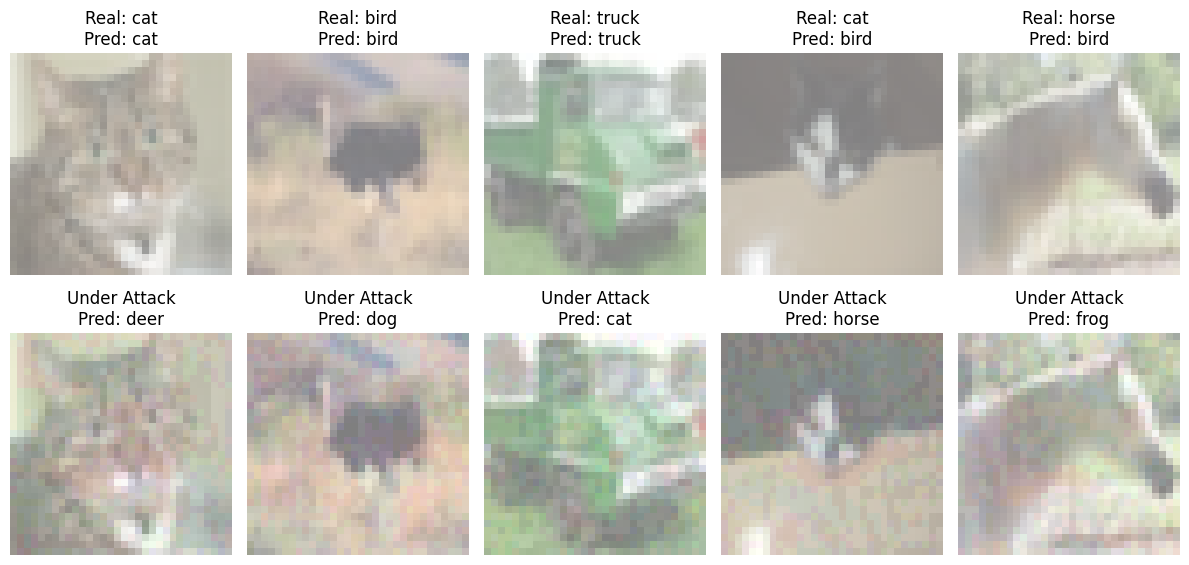

In [ ]:
# Visualize attack impact with epsilon=0.01
epsilon = .05
plot_attack_classification(net, test_loader, epsilon, class_names=class_names)

### Evaluate Accuracy Under FGSM Attacks

Epsilon: 0.00, Accuracy: 61.82%
Epsilon: 0.01, Accuracy: 22.85%
Epsilon: 0.05, Accuracy: 1.56%
Epsilon: 0.10, Accuracy: 0.49%
Epsilon: 0.15, Accuracy: 0.68%
Epsilon: 0.20, Accuracy: 0.59%
Epsilon: 0.25, Accuracy: 1.17%


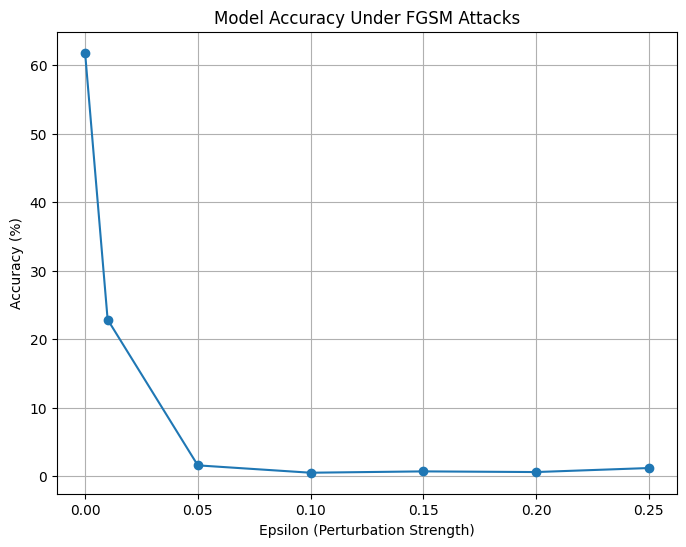

In [ ]:
# Cell: Evaluate Accuracy Under FGSM Attacks
def evaluate_under_attack(model, test_loader, epsilons):
    """
    Evaluate and plot the model's accuracy under FGSM attacks with varying epsilon values.

    Args:
        model: Trained model to evaluate.
        test_loader: DataLoader for test data.
        epsilons: List of epsilon values to test.
    """
    accuracies = []

    for epsilon in epsilons:
        acc = test_with_fgsm(model, test_loader, epsilon)
        accuracies.append(acc)
        print(f"Epsilon: {epsilon:.2f}, Accuracy: {acc:.2f}%")

    # Plot results
    plt.figure(figsize=(8, 6))
    plt.plot(epsilons, accuracies, marker='o')
    plt.title("Model Accuracy Under FGSM Attacks")
    plt.xlabel("Epsilon (Perturbation Strength)")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.show()

# Test the model under attack for different epsilon values
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
evaluate_under_attack(net, test_loader, epsilons)

plot showing how the model’s accuracy decreases as the strength of the attack $\epsilon$ increases.

Understanding adversarial attacks like FGSM is crucial because:

	•	It highlights vulnerabilities in machine learning models.
	•	It helps in designing robust models that are resilient to adversarial attacks.
	•	It demonstrates how even small changes to inputs can significantly affect model predictions.

# Projected Gradient Descent (PGD)

## What is PGD?

Projected Gradient Descent (PGD) is an iterative method for generating adversarial examples. It is an extension of FGSM, where instead of applying the gradient sign attack in one step, the attack is applied iteratively with smaller steps. Additionally, after each step, the perturbed input is projected back into an $\ell_\infty$-norm ball around the original input to ensure the perturbation is bounded.

The formula for PGD is:


$$x_{\text{adv}}^{t+1} = \text{Proj}{\mathcal{B}_\epsilon(x)} \left( x_{\text{adv}}^t + \alpha \cdot \text{sign}(\nabla_x \mathcal{L}(x_{\text{adv}}^t, y)) \right)$$


Where:

* $x_{\text{adv}}^t:$ Adversarial example at step t.
* $\mathcal{B}_\epsilon(x):$ $\ell\infty$-norm ball of radius $\epsilon$ around the original input x.
* $\alpha:$ Step size for each iteration.
* $\text{Proj}:$ Projection operator to clip the adversarial example to the valid range [0, 1] and ensure it stays within the $\ell_\infty$-norm ball.

## Implementation PGD

### 1. PGD Function

This function performs the PGD attack for a batch of inputs.

In [ ]:
# Cell: PGD Attack Implementation
def pgd_attack(model, inputs, labels, epsilon, alpha, num_iter):
    """
    Perform PGD attack on a batch of inputs.

    Args:
        model: Trained model to attack.
        inputs: Original input images (tensor).
        labels: True labels for the inputs (tensor).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of iterations for the attack.

    Returns:
        adversarial_inputs: Adversarial examples generated from inputs.
    """
    # Clone the original inputs to initialize adversarial examples
    adversarial_inputs = inputs.clone().detach().to(device)
    adversarial_inputs.requires_grad = True

    for i in range(num_iter):
        # Forward pass: compute predictions and loss
        outputs = model(adversarial_inputs)
        loss = nn.NLLLoss()(outputs, labels)

        # Backward pass: compute gradients
        model.zero_grad()
        loss.backward()

        # Update adversarial examples using gradient sign
        with torch.no_grad():
            adversarial_inputs = adversarial_inputs + alpha * adversarial_inputs.grad.sign()

            # Clip to the epsilon ball
            perturbation = torch.clamp(adversarial_inputs - inputs, min=-epsilon, max=epsilon)
            adversarial_inputs = torch.clamp(inputs + perturbation, min=0, max=1)

        # Detach and re-enable gradients for the next iteration
        adversarial_inputs.requires_grad = True

    return adversarial_inputs

### 2. Testing with PGD

We evaluate the model’s accuracy on adversarial examples generated using PGD.

In [ ]:
# Cell: PGD Testing
def test_with_pgd(model, test_loader, epsilon, alpha, num_iter):
    """
    Test the model on adversarial examples generated using PGD.

    Args:
        model: Trained model to test.
        test_loader: DataLoader for the test dataset.
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of iterations for the attack.

    Returns:
        accuracy: Model accuracy on adversarial examples.
    """
    correct = 0
    total = 0

    # Iterate over the test data
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # Generate adversarial examples
        adversarial_inputs = pgd_attack(model, inputs, labels, epsilon, alpha, num_iter)

        # Re-classify the adversarial examples
        outputs = model(adversarial_inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy

### 3. Running PGD and Observing Results

We test the model under attack using different $\epsilon$ values and a fixed step size $\alpha$ and number of iterations.

In [ ]:
# Cell: Evaluate Model Under PGD Attacks
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
alpha = 0.01  # Step size
num_iter = 10  # Number of iterations

# Load the trained model
net = Net().to(device)
net.load("cifar10_model.pth")

# Test the model on adversarial examples for different epsilon values
results = {}
for eps in epsilons:
    acc = test_with_pgd(net, test_loader, eps, alpha, num_iter)
    results[eps] = acc
    print(f"Epsilon: {eps}, Accuracy Under Attack: {acc:.2f}%")

Epsilon: 0, Accuracy Under Attack: 61.82%
Epsilon: 0.01, Accuracy Under Attack: 15.92%
Epsilon: 0.05, Accuracy Under Attack: 0.10%
Epsilon: 0.1, Accuracy Under Attack: 0.00%
Epsilon: 0.15, Accuracy Under Attack: 0.00%
Epsilon: 0.2, Accuracy Under Attack: 0.00%
Epsilon: 0.25, Accuracy Under Attack: 0.00%


### 4. Plot Accuracy Under PGD Attack

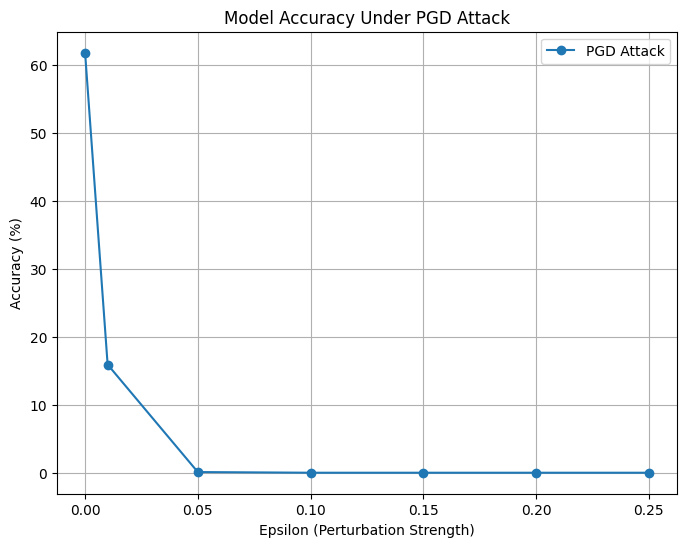

In [ ]:
# Cell: Plot Accuracy vs. Epsilon for PGD
def plot_pgd_results(epsilons, results):
    """
    Plot model accuracy under PGD attack for varying epsilon values.

    Args:
        epsilons: List of epsilon values.
        results: Dictionary of epsilon values and corresponding accuracies.
    """
    accuracies = [results[eps] for eps in epsilons]

    plt.figure(figsize=(8, 6))
    plt.plot(epsilons, accuracies, marker='o', label="PGD Attack")
    plt.title("Model Accuracy Under PGD Attack")
    plt.xlabel("Epsilon (Perturbation Strength)")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()

# Plot the results
plot_pgd_results(epsilons, results)

### 5. Display results for PGD Attack

In [ ]:
# Cell: Visualize Attack Impact on Classification
def plot_attack_classification(model, data_loader, epsilon, alpha, num_iter, class_names):
    """
    Visualize the impact of PGD attacks on classification.

    Args:
        model: Trained model to attack.
        data_loader: DataLoader for test data.
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of iterations for the attack.
        class_names: List of class names corresponding to CIFAR-10 dataset.
    """
    data_iter = iter(data_loader)
    inputs, labels = next(data_iter)

    # Generate adversarial examples
    inputs = inputs.to(device)
    labels = labels.to(device)
    adversarial_inputs = pgd_attack(model, inputs, labels, epsilon, alpha, num_iter)

    # Get predictions for both original and adversarial examples
    model.eval()
    with torch.no_grad():
        outputs_original = model(inputs)
        outputs_adversarial = model(adversarial_inputs)
        _, predicted_original = torch.max(outputs_original.data, 1)
        _, predicted_adversarial = torch.max(outputs_adversarial.data, 1)

    # Convert tensors to numpy for visualization
    inputs = inputs.cpu().detach().numpy()
    adversarial_inputs = adversarial_inputs.cpu().detach().numpy()

    # Plot original and adversarial images with labels
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(5):
        # Original images
        axes[0, i].imshow(inputs[i].transpose(1, 2, 0) * 0.5 + 0.5)
        axes[0, i].set_title(f"Real: {class_names[labels[i].item()]}\nPred: {class_names[predicted_original[i].item()]}")
        axes[0, i].axis('off')

        # Adversarial images
        axes[1, i].imshow(adversarial_inputs[i].transpose(1, 2, 0) * 0.5 + 0.5)
        axes[1, i].set_title(f"Under Attack\nPred: {class_names[predicted_adversarial[i].item()]}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Class names for CIFAR-10
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]



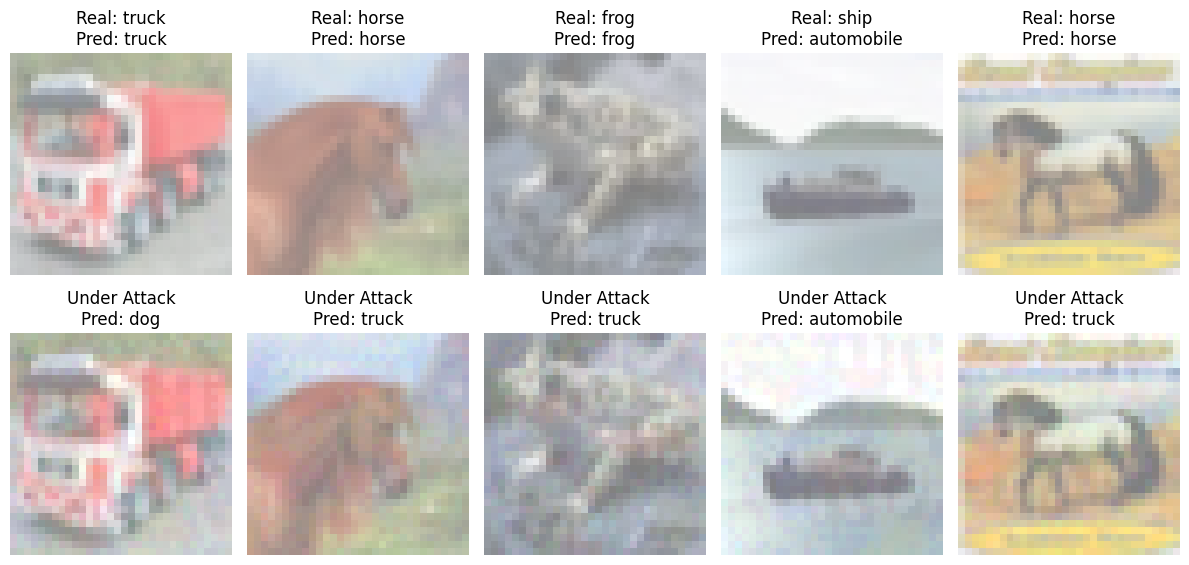

In [ ]:
# Visualize attack impact with epsilon=0.01
epsilon = .05
alpha = 0.01  # Step size
num_iter = 10  # Number of iterations
plot_attack_classification(net, test_loader, epsilon, alpha, num_iter, class_names=class_names)

# Adversarial Training

# What is Adversarial Training?

Adversarial training is a defense mechanism that integrates adversarial examples into the training process. During training, the model learns to minimize the loss on both clean and adversarial examples, making it more robust to adversarial attacks.

The training process alternates between:

1.	Generating adversarial examples (e.g., using PGD or FGSM).
2.	Updating the model parameters to reduce the loss on these adversarial examples.

## Implementation of Adversarial Training

### 1.Define Adversarial Training Function

This function trains the model with a mix of clean and adversarial examples in each batch.

In [ ]:
# Cell: Adversarial Training Implementation
def adversarial_training(
    model, train_loader, optimizer, num_epochs, epsilon, alpha, num_iter
):
    """
    Train the model using adversarial training with PGD.

    Args:
        model: The model to train.
        train_loader: DataLoader for the training dataset.
        optimizer: Optimizer for training.
        num_epochs: Number of training epochs.
        epsilon: Maximum perturbation for PGD attack.
        alpha: Step size for PGD.
        num_iter: Number of iterations for PGD.

    Returns:
        Trained model.
    """
    model.train()
    criterion = nn.NLLLoss()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Generate adversarial examples using PGD
            adversarial_inputs = pgd_attack(model, inputs, labels, epsilon, alpha, num_iter)

            # Combine clean and adversarial examples
            combined_inputs = torch.cat([inputs, adversarial_inputs], dim=0)
            combined_labels = torch.cat([labels, labels], dim=0)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(combined_inputs)
            loss = criterion(outputs, combined_labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    return model

### 2. Training the Model with Adversarial Examples

To perform adversarial training, we’ll use the adversarial_training function and save the trained model for later evaluation.

In [ ]:
# Define data transformations for training
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL.Image to Tensor

])

# Initialize the CIFAR-10 dataset with transforms
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

# Create the DataLoader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

In [ ]:
# Define data transformations for testing
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL.Image to Tensor
])

# Initialize the CIFAR-10 test dataset with transforms
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

# Create the DataLoader
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [ ]:
# Cell: Train Model with Adversarial Training
# Define model, optimizer, and parameters
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Parameters for adversarial training
num_epochs = 10
epsilon = 0.1  # Maximum perturbation
alpha = 0.01   # Step size
num_iter = 7   # Number of PGD iterations

# Train the model
print("Starting Adversarial Training...")
net = adversarial_training(net, train_loader, optimizer, num_epochs, epsilon, alpha, num_iter)

# Save the adversarially trained model
net.save("adv_trained_model.pth")
print("Adversarially trained model saved.")

Starting Adversarial Training...
Epoch 1/10, Loss: 2.2181
Epoch 2/10, Loss: 2.1105
Epoch 3/10, Loss: 2.0633
Epoch 4/10, Loss: 2.0449
Epoch 5/10, Loss: 2.0306
Epoch 6/10, Loss: 2.0215
Epoch 7/10, Loss: 2.0144
Epoch 8/10, Loss: 2.0088
Epoch 9/10, Loss: 2.0022
Epoch 10/10, Loss: 1.9982
Adversarially trained model saved.


### 3. Testing the Adversarially Trained Model

Evaluate the adversarially trained model to measure its robustness against attacks.

In [ ]:
# Cell: Evaluate Adversarially Trained Model
# Load the adversarially trained model
net.load("adv_trained_model.pth")
net.eval()

# Test clean accuracy
clean_acc = test_natural(net, test_loader)
print(f"Clean Accuracy: {clean_acc:.2f}%")

# Test robustness under PGD attack
adv_acc = test_with_pgd(net, test_loader, epsilon=0.1, alpha=0.01, num_iter=7)
print(f"Adversarial Accuracy (PGD, epsilon=0.1): {adv_acc:.2f}%")

Clean Accuracy: 39.49%
Adversarial Accuracy (PGD, epsilon=0.1): 15.38%


### 4. Comparing Results

We compare the performance of the adversarially trained model with the original (clean-trained) model.

In [ ]:
# Cell: Compare Results Before and After Adversarial Training
# Load original clean-trained model
clean_model = Net().to(device)
clean_model.load("cifar10_model.pth")

# Evaluate clean-trained model
clean_model_acc = test_natural(clean_model, test_loader)
clean_model_adv_acc = test_with_pgd(clean_model, test_loader, epsilon=0.1, alpha=0.01, num_iter=7)

# Evaluate adversarially trained model
adv_model_acc = clean_acc  # Already computed above
adv_model_adv_acc = adv_acc  # Already computed above

# Print results
print("Comparison of Model Performance:")
print(f"Clean-Trained Model - Clean Accuracy: {clean_model_acc:.2f}%, Adversarial Accuracy: {clean_model_adv_acc:.2f}%")
print(f"Adversarially Trained Model - Clean Accuracy: {adv_model_acc:.2f}%, Adversarial Accuracy: {adv_model_adv_acc:.2f}%")

Comparison of Model Performance:
Clean-Trained Model - Clean Accuracy: 61.34%, Adversarial Accuracy: 0.02%
Adversarially Trained Model - Clean Accuracy: 39.49%, Adversarial Accuracy: 15.38%


### 5. Visualizing Results

Plot a comparison of clean and adversarial accuracy for both the clean-trained and adversarially trained models.

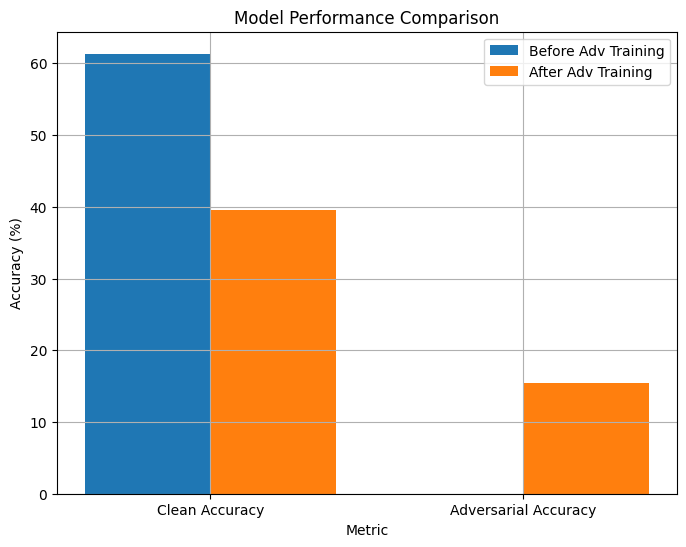

In [ ]:
# Cell: Plot Model Performance Comparison
import matplotlib.pyplot as plt

def plot_comparison(clean_model_results, adv_model_results):
    """
    Plot a comparison of clean-trained and adversarially trained models.

    Args:
        clean_model_results: (clean_accuracy, adversarial_accuracy) for clean-trained model.
        adv_model_results: (clean_accuracy, adversarial_accuracy) for adversarially trained model.
    """
    labels = ["Clean Accuracy", "Adversarial Accuracy"]
    clean_values = clean_model_results
    adv_values = adv_model_results

    x = range(len(labels))

    plt.figure(figsize=(8, 6))
    plt.bar(x, clean_values, width=0.4, label="Before Adv Training", align='center')
    plt.bar([p + 0.4 for p in x], adv_values, width=0.4, label="After Adv Training", align='center')

    plt.title("Model Performance Comparison")
    plt.xlabel("Metric")
    plt.ylabel("Accuracy (%)")
    plt.xticks([p + 0.2 for p in x], labels)
    plt.legend()
    plt.grid()
    plt.show()

# Results for plotting
clean_model_results = (clean_model_acc, clean_model_adv_acc)
adv_model_results = (adv_model_acc, adv_model_adv_acc)

# Plot comparison
plot_comparison(clean_model_results, adv_model_results)

## Questions

1. Do one of the following activities with this model:

   a. Perform some ablation studies on the simple CNN model provided here. You could change the number and size of layers, add in skip connections, or change the FC layers to convolutions and assess performance on the adversarial training task.

   b.   Are Simple models (like FC and CNNs) more susceptible to adversarial attacks? Implement adversarial training on a `ResNet18` model that is trained on ImageNet 1K data. We will provide instructions on how to read in the model and the ImageNet data. You should then be able to run the attacks and see the effect on the network.

   Evaluate and report the model performance on both clean and adversarial samples. What differences do you observe, and how does adversarial training impact robustness?


2.   Can Data Augmentation techniques (random noise/rotations/ transformations) during training make the model robust? Select and implement one data augmentation technique. Measure its effect on model accuracy under adversarial perturbations and discuss your findings.

3. What are some effective techniques to improve a model's resilience against adversarial perturbations? Provide some logical explanation for your proposed techniques.

In [31]:
%%bash
cd /content/drive/MyDrive/Colab_EE428/Colab_S2024/A3
git remote -v

git config --global user.email "jmkrause@iastate.edu"
git config --global user.name "Jack Krause"

git add --all
git commit -m "save"
git push
# git branch adversarial
git checkout adversarial
push -u origin adversarial



origin	git@github.com:Jack-Krause/EE428HW3.git (fetch)
origin	git@github.com:Jack-Krause/EE428HW3.git (push)
[adversarial 771a21f] save
 2 files changed, 2 insertions(+), 2 deletions(-)
 rewrite HW3_adversarial_training_cifar_10.ipynb (94%)


fatal: The current branch adversarial has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream origin adversarial

fatal: A branch named 'adversarial' already exists.
Already on 'adversarial'
bash: line 12: push: command not found


CalledProcessError: Command 'b'cd /content/drive/MyDrive/Colab_EE428/Colab_S2024/A3\ngit remote -v\n\ngit config --global user.email "jmkrause@iastate.edu"\ngit config --global user.name "Jack Krause"\n\ngit add --all\ngit commit -m "save"\ngit push\ngit branch adversarial\ngit checkout adversarial\npush -u origin adversarial\n\n'' returned non-zero exit status 127.